# Performance Comparison of the TPOT and H2O AutoML Algorithms

## Classification

### Loading data

In [1]:
# Importing dependencies
import tpot
from tpot import TPOTClassifier, TPOTRegressor
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Loading a dataset for training
data = datasets.load_breast_cancer()

# Splitting our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["data"], 
                                                    data["target"], 
                                                    test_size=0.2, 
                                                    stratify=data["target"])

### Classification in 3 minutes (no early stopping)

#### TPOT classification performance in 3 minutes

In [2]:
# Function for creating a TPOT optimizer
def create_tpot_optimizer(mode, 
                          max_time_mins, 
                          generations=None, 
                          population_size=100,
                          offspring_size=100,                           
                          early_stop=None, 
                          template=None):    
    # TPOT classifier
    if mode == "classification":
        optimizer = TPOTClassifier(generations=generations,
                                   population_size=population_size,
                                   offspring_size=offspring_size,
                                   random_state=1,
                                   max_time_mins=max_time_mins,
                                   scoring="roc_auc",
                                   verbosity=2,
                                   early_stop=early_stop,
                                   use_dask=True,
                                   template=template,
                                   n_jobs=10)
    # TPOT regressor
    elif mode == "regression":        
        optimizer = TPOTRegressor(generations=generations,
                                  population_size=population_size,
                                  offspring_size=offspring_size,
                                  random_state=1,
                                  max_time_mins=max_time_mins,
                                  scoring="neg_root_mean_squared_error",
                                  verbosity=2,
                                  early_stop=early_stop,
                                  use_dask=True,
                                  template=template,
                                  n_jobs=10)
        
    return optimizer

In [3]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=3)

In [4]:
# Function for training and evaluating the TPOT optimizer
def train_eval_tpot(optimizer, 
                    train_features, train_labels, 
                    test_features, test_labels):
    # Fitting the optimizer
    optimizer.fit(train_features, 
                  train_labels)
    
    # Obtaining the best pipeline
    best_pipeline = optimizer.fitted_pipeline_
    
    # Evaluating performance on the test set
    score = pipeline_optimizer.score(test_features, 
                                     test_labels)
    
    return best_pipeline, score    

In [5]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best model and test AUC
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT in 3 minutes: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9953560371517026

Generation 2 - Current best internal CV score: 0.9953560371517026

Generation 3 - Current best internal CV score: 0.9955624355005159

4.36 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LogisticRegression(MaxAbsScaler(input_matrix), C=10.0, dual=False, penalty=l2)

### BEST PIPELINE ###
Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('logisticregression',
                 LogisticRegression(C=10.0, random_state=1))])

Test AUC achieved with TPOT in 3 minutes: 0.99008

Wall time: 4min 22s


#### H2O classification performance in 3 minutes

In [6]:
# Importing dependencies
import h2o
from h2o.automl import H2OAutoML
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Initializing our H2O cluster
h2o.init(name="h2ocluster", nthreads=10)

# Creating H2OFrame objects for train data
train_features = h2o.H2OFrame(X_train, column_names=list(data["feature_names"]))
train_labels = h2o.H2OFrame(y_train, column_names=["target"])

# Creating H2OFrame objects for test data
test_features = h2o.H2OFrame(X_test, column_names=list(data["feature_names"]))
test_labels = h2o.H2OFrame(y_test, column_names=["target"])

# Joining our features and labels
train_frame = train_features.cbind(train_labels)
test_frame = test_features.cbind(test_labels)    

# Specifying feature and target names for training
x = train_frame.columns
y = "target"
x.remove(y)

# Converting labels to categoricals
train_frame[y] = train_frame[y].asfactor()
test_frame[y] = test_frame[y].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.311-b11, mixed mode)
  Starting server from C:\Users\tigra\AppData\Local\Programs\Python\Python39\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tigra\AppData\Local\Temp\tmpiwruav7h
  JVM stdout: C:\Users\tigra\AppData\Local\Temp\tmpiwruav7h\h2o_tigra_started_from_python.out
  JVM stderr: C:\Users\tigra\AppData\Local\Temp\tmpiwruav7h\h2o_tigra_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Yerevan
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,1 month and 21 days
H2O_cluster_name:,h2ocluster
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.545 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
# Function for creating H2O AutoML
def create_h2o_automl(mode, 
                      max_runtime_secs, 
                      max_models=None, 
                      stopping_rounds=0):
    # Selecting a sorting metric based on task
    if mode == "classification":
        sort_metric = "AUC"
    elif mode == "regression":
        sort_metric = "RMSE"
    
    # Instantiating an H2O AutoML object
    aml = H2OAutoML(seed=1, 
                    max_runtime_secs=max_runtime_secs, 
                    max_models=max_models, 
                    verbosity="info", 
                    stopping_rounds=stopping_rounds, 
                    sort_metric=sort_metric)
        
    return aml

In [8]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="classification", 
                        max_runtime_secs=180)

In [9]:
# Function for training and evaluating H2OAutoML
def train_eval_h2o(automl, 
                   x, y, 
                   train_frame, 
                   test_frame):
    automl.train(x=x, y=y, 
                 training_frame=train_frame)
    
    lb = aml.leaderboard
    score = automl.leader.model_performance(test_frame)
    
    return lb, score

In [10]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, 
                               test_frame)

# Viewing the leaderboard and test AUC
print("\n### EVALUATED MODELS ###\n"
      f"{lb}")
print(f"\nTest AUC achieved with H2O in 3 minutes: {h2o_score.auc():.5f}\n")

AutoML progress: |
00:05:07.353: Project: AutoML_20211024_00507351
00:05:07.355: Setting stopping tolerance adaptively based on the training frame: 0.04688072309384954
00:05:07.355: Build control seed: 1
00:05:07.355: training frame: Frame key: automl_training_py_2_sid_9c47    cols: 31    rows: 455  chunks: 1    size: 40509  checksum: 913256392876034504
00:05:07.355: validation frame: NULL
00:05:07.356: leaderboard frame: NULL
00:05:07.356: blending frame: NULL
00:05:07.356: response column: target
00:05:07.356: fold column: null
00:05:07.356: weights column: null
00:05:07.367: AutoML: XGBoost is not available; skipping it.
00:05:07.370: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
00:05:07.378: Disabling Algo: XGBoost as requested by the user.
00:05:07.3

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_20211024_000507,0.996987,0.0729719,0.998172,0.0270382,0.142757,0.0203795
DeepLearning_grid__1_AutoML_20211024_000507_model_4,0.996677,0.0915077,0.997958,0.0258514,0.144412,0.0208549
DeepLearning_grid__2_AutoML_20211024_000507_model_2,0.996275,0.152323,0.99769,0.0352941,0.163302,0.0266676
DeepLearning_grid__1_AutoML_20211024_000507_model_1,0.996037,0.0941272,0.997547,0.0358617,0.155463,0.0241688
DeepLearning_grid__1_AutoML_20211024_000507_model_6,0.995955,0.0899974,0.997537,0.030547,0.153987,0.0237121
DeepLearning_grid__2_AutoML_20211024_000507_model_1,0.995748,0.124725,0.997396,0.0341073,0.172565,0.0297786
DeepLearning_grid__1_AutoML_20211024_000507_model_5,0.995655,0.159158,0.997261,0.0211558,0.13987,0.0195636
StackedEnsemble_BestOfFamily_AutoML_20211024_000507,0.995645,0.0752727,0.997292,0.0287926,0.146813,0.021554
StackedEnsemble_AllModels_AutoML_20211024_000507,0.995624,0.121702,0.997206,0.0229102,0.153418,0.0235372
DeepLearning_grid__2_AutoML_20211024_000507_model_4,0.995273,0.105346,0.99709,0.0276058,0.156815,0.0245911



### EVALUATED MODELS ###


Test AUC achieved with H2O in 3 minutes: 0.99041

Wall time: 2min 37s


#### TPOT classification performance in 3 minutes with a classifier only

In [11]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=3, 
                                           template="Classifier")

In [12]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Running the TPOT pipeline optimizer and tracking time
print("\n### BEST PIPELINE ### \n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT (classifier only) in 3 minutes: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9954592363261094

Generation 2 - Current best internal CV score: 0.9954592363261094

Generation 3 - Current best internal CV score: 0.9954592363261094

Generation 4 - Current best internal CV score: 0.9954592363261094

3.94 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=2, max_features=0.7500000000000001, min_samples_leaf=11, min_samples_split=16, n_estimators=100, subsample=0.7500000000000001)

### BEST PIPELINE ### 
Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.5, max_depth=2,
                                            max_features=0.7500000000000001,
                                            min_samples_leaf=11,
                                            min_samples_split=16,
  

### Classification with early stopping (within 60 minutes)

#### TPOT classification performance with early stopping

In [13]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=60, 
                                           early_stop=2)

In [14]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test AUC
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT with early stopping: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9953560371517026

Generation 2 - Current best internal CV score: 0.9953560371517026

Generation 3 - Current best internal CV score: 0.9953560371517026

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LogisticRegression(MaxAbsScaler(input_matrix), C=20.0, dual=False, penalty=l2)

### BEST PIPELINE ###
Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('logisticregression',
                 LogisticRegression(C=20.0, random_state=1))])

Test AUC achieved with TPOT with early stopping: 0.99107

Wall time: 4min 1s


#### H2O classification performance with early stopping

In [15]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="classification", 
                        max_runtime_secs=3600, 
                        stopping_rounds=2)

In [16]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, 
                               test_frame)

# Viewing the leaderboard and test AUC
print("\n### EVALUATED MODELS###\n"
      f"{lb}")
print(f"\nTest AUC achieved with H2O with early stopping: {h2o_score.auc():.5f}\n")

AutoML progress: |
00:15:42.630: Project: AutoML_20211024_01542630
00:15:42.631: Setting stopping tolerance adaptively based on the training frame: 0.04688072309384954
00:15:42.631: Build control seed: 1
00:15:42.631: training frame: Frame key: automl_training_py_2_sid_9c47    cols: 31    rows: 455  chunks: 1    size: 40509  checksum: 913256392876034504
00:15:42.631: validation frame: NULL
00:15:42.631: leaderboard frame: NULL
00:15:42.631: blending frame: NULL
00:15:42.631: response column: target
00:15:42.631: fold column: null
00:15:42.631: weights column: null
00:15:42.631: AutoML: XGBoost is not available; skipping it.
00:15:42.631: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
00:15:42.631: Disabling Algo: XGBoost as requested by the user.
00:15:42.6

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DeepLearning_grid__1_AutoML_20211024_001542_model_34,0.997853,0.0684898,0.998684,0.019969,0.130617,0.0170608
DeepLearning_grid__2_AutoML_20211024_001542_model_45,0.997461,0.0735867,0.998381,0.0152735,0.11655,0.0135839
DeepLearning_grid__2_AutoML_20211024_001542_model_43,0.997441,0.0676967,0.998405,0.0164603,0.126232,0.0159346
DeepLearning_grid__1_AutoML_20211024_001542_model_7,0.997379,0.0918726,0.9984,0.0234778,0.145278,0.0211057
DeepLearning_grid__3_AutoML_20211024_001542_model_45,0.997162,0.116923,0.998242,0.028225,0.138778,0.0192594
DeepLearning_grid__2_AutoML_20211024_001542_model_13,0.997152,0.0783809,0.998215,0.0294118,0.135281,0.0183009
DeepLearning_grid__2_AutoML_20211024_001542_model_44,0.997131,0.0669992,0.998192,0.0217234,0.130748,0.017095
DeepLearning_grid__2_AutoML_20211024_001542_model_26,0.99709,0.0775443,0.998213,0.028225,0.139822,0.0195502
DeepLearning_grid__1_AutoML_20211024_001542_model_14,0.997028,0.0796147,0.998174,0.0223426,0.137877,0.0190101
DeepLearning_grid__3_AutoML_20211024_001542_model_36,0.997007,0.0941587,0.998145,0.024097,0.13643,0.0186132



### EVALUATED MODELS###


Test AUC achieved with H2O with early stopping: 0.98264

Wall time: 40min 9s


#### TPOT classification performance with early stopping (classifier only)

In [17]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=60, 
                                           early_stop=2, 
                                           template="Classifier")

In [18]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test AUC
print("\n### BEST PIPELINE ### \n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT with early stopping & classifier only: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9954592363261094

Generation 2 - Current best internal CV score: 0.9954592363261094

Generation 3 - Current best internal CV score: 0.9954592363261094

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=2, max_features=0.7500000000000001, min_samples_leaf=11, min_samples_split=16, n_estimators=100, subsample=0.7500000000000001)

### BEST PIPELINE ### 
Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.5, max_depth=2,
                                            max_features=0.7500000000000001,
                                            min_samples_leaf=11,
                                            min_samples_split=16,
                                            random_state

### Classification with 50 models/pipelines

#### TPOT classification with 50 pipelines

In [19]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=None, 
                                           generations=4,
                                           population_size=10, 
                                           offspring_size=10)

In [20]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test AUC
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT after training 30 pipelines: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.992672858617131

Generation 2 - Current best internal CV score: 0.992672858617131

Generation 3 - Current best internal CV score: 0.9943240454076367

Generation 4 - Current best internal CV score: 0.996904024767802

Best pipeline: GradientBoostingClassifier(CombineDFs(input_matrix, Normalizer(input_matrix, norm=l2)), learning_rate=0.5, max_depth=1, max_features=0.7500000000000001, min_samples_leaf=7, min_samples_split=13, n_estimators=100, subsample=0.7500000000000001)

### BEST PIPELINE ###
Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer',
                                                 FunctionTransformer(func=<function copy at 0x000002B4DFC10CA0>)),
                                                ('normalizer', Normalizer())])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.5, max_depth=1,
                             

#### H2O classification with 50 models

In [21]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="classification", 
                        max_runtime_secs=0, 
                        max_models=50)

In [22]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, test_frame)

# Viewing the leaderboard and test AUC
print("\n### EVALUATED MODELS ###\n"
      f"{lb}")
print(f"\nTest AUC achieved with H2O with 50 models: {h2o_score.auc():.5f}\n")

AutoML progress: |
14:14:18.279: Project: AutoML_20211024_141418276
14:14:18.281: Setting stopping tolerance adaptively based on the training frame: 0.04688072309384954
14:14:18.281: Build control seed: 1
14:14:18.281: training frame: Frame key: automl_training_py_2_sid_9bc1    cols: 31    rows: 455  chunks: 1    size: 40509  checksum: -528629061954570698
14:14:18.281: validation frame: NULL
14:14:18.281: leaderboard frame: NULL
14:14:18.281: blending frame: NULL
14:14:18.281: response column: target
14:14:18.282: fold column: null
14:14:18.282: weights column: null
14:14:18.295: AutoML: XGBoost is not available; skipping it.
14:14:18.298: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
14:14:18.308: Disabling Algo: XGBoost as requested by the user.
14:14:18

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DeepLearning_grid__3_AutoML_20211024_141418_model_6,0.99678,0.105057,0.997945,0.0229102,0.13388,0.0179239
DeepLearning_grid__3_AutoML_20211024_141418_model_2,0.996533,0.0960036,0.997795,0.024097,0.134843,0.0181825
DeepLearning_grid__1_AutoML_20211024_141418_model_3,0.996182,0.0821225,0.997548,0.0229102,0.142291,0.0202468
DeepLearning_grid__1_AutoML_20211024_141418_model_5,0.99614,0.081236,0.997439,0.0194014,0.1206,0.0145444
DeepLearning_grid__1_AutoML_20211024_141418_model_6,0.995955,0.0874829,0.997494,0.0228586,0.150379,0.0226139
DeepLearning_grid__1_AutoML_20211024_141418_model_1,0.995542,0.0932452,0.99713,0.0293602,0.14595,0.0213014
DeepLearning_grid__1_AutoML_20211024_141418_model_7,0.995439,0.0830418,0.996789,0.0170279,0.129029,0.0166485
DeepLearning_grid__3_AutoML_20211024_141418_model_5,0.995222,0.146628,0.997059,0.0193498,0.164786,0.0271543
StackedEnsemble_AllModels_AutoML_20211024_141418,0.995129,0.133201,0.996804,0.0187822,0.164024,0.0269039
StackedEnsemble_BestOfFamily_AutoML_20211024_141418,0.995088,0.0710021,0.996531,0.019969,0.133159,0.0177315



### EVALUATED MODELS ###


Test AUC achieved with H2O with 50 models: 0.99239

Wall time: 1h 7min 16s


#### TPOT classification with 50 pipelines (classifier only)

In [23]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="classification", 
                                           max_time_mins=None, 
                                           generations=4,
                                           population_size=10, 
                                           offspring_size=10,
                                           template="Classifier")

In [24]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test AUC
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest AUC achieved with TPOT after training 50 pipelines (classifier only): {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9925696594427244

Generation 2 - Current best internal CV score: 0.9925696594427244

Generation 3 - Current best internal CV score: 0.9925696594427244

Generation 4 - Current best internal CV score: 0.9927760577915377

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=3, min_samples_split=3, n_estimators=100)

### BEST PIPELINE ###
Pipeline(steps=[('extratreesclassifier',
                 ExtraTreesClassifier(criterion='entropy', max_features=0.45,
                                      min_samples_leaf=3, min_samples_split=3,
                                      random_state=1))])

Test AUC achieved with TPOT after training 50 pipelines (classifier only): 0.98413

Wall time: 23.4 s


## Regression

In [25]:
# Loading a dataset for training
data = datasets.load_diabetes()

# Splitting our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data["data"], 
                                                    data["target"], 
                                                    test_size=0.2)

### Regression in 3 minutes

#### TPOT regression performance in 3 minutes

In [26]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=3)

In [27]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest RMSE achieved with TPOT in 3 minutes: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.352735491979296

Generation 2 - Current best internal CV score: -53.34170127564374

Generation 3 - Current best internal CV score: -53.34170127564374

3.07 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(PCA(input_matrix, iterated_power=5, svd_solver=randomized), normalize=True)

### BEST PIPELINE ###
Pipeline(steps=[('pca',
                 PCA(iterated_power=5, random_state=1,
                     svd_solver='randomized')),
                ('lassolarscv', LassoLarsCV(normalize=True))])

Test RMSE achieved with TPOT in 3 minutes: -58.88185

Wall time: 3min 4s


#### H2O regression performance in 3 minutes

In [28]:
# Creating H2OFrame objects for train data
train_features = h2o.H2OFrame(X_train, column_names=list(data["feature_names"]))
train_labels = h2o.H2OFrame(y_train, column_names=["target"])

# Creating H2OFrame objects for test data
test_features = h2o.H2OFrame(X_test, column_names=list(data["feature_names"]))
test_labels = h2o.H2OFrame(y_test, column_names=["target"])

# Joining our features and labels
train_frame = train_features.cbind(train_labels)
test_frame = test_features.cbind(test_labels)    

# Specifying feature and target names for training
x = train_frame.columns
y = "target"
x.remove(y)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [29]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="regression", 
                        max_runtime_secs=180)

In [30]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, 
                               test_frame)

# Viewing the leaderboard and test RMSE
print("\n### EVALUATED MODELS ###\n"
      f"{lb}")
print(f"\nTest RMSE achieved with H2O in 3 minutes: {h2o_score.rmse():.5f}\n")

AutoML progress: |
15:25:03.512: Project: AutoML_20211024_152503512
15:25:03.512: Setting stopping tolerance adaptively based on the training frame: 0.05
15:25:03.512: Build control seed: 1
15:25:03.512: training frame: Frame key: automl_training_py_497_sid_9bc1    cols: 11    rows: 353  chunks: 1    size: 16936  checksum: -7230522126757213732
15:25:03.512: validation frame: NULL
15:25:03.512: leaderboard frame: NULL
15:25:03.512: blending frame: NULL
15:25:03.512: response column: target
15:25:03.512: fold column: null
15:25:03.513: weights column: null
15:25:03.513: AutoML: XGBoost is not available; skipping it.
15:25:03.513: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
15:25:03.513: Disabling Algo: XGBoost as requested by the user.
15:25:03.513: AutoML

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
DeepLearning_grid__1_AutoML_20211024_152503_model_6,53.8093,2895.45,2895.45,43.6601,0.405631
StackedEnsemble_BestOfFamily_AutoML_20211024_152503,53.8892,2904.04,2904.04,43.8312,0.406853
DeepLearning_grid__1_AutoML_20211024_152503_model_4,54.3713,2956.23,2956.23,43.9683,0.405893
GLM_1_AutoML_20211024_152503,54.4876,2968.9,2968.9,44.1634,0.411197
DeepLearning_grid__2_AutoML_20211024_152503_model_4,54.8525,3008.79,3008.79,44.2871,0.410415
DeepLearning_grid__1_AutoML_20211024_152503_model_1,55.0053,3025.58,3025.58,44.1594,0.413733
StackedEnsemble_AllModels_AutoML_20211024_152503,55.1701,3043.74,3043.74,45.2439,0.415623
DeepLearning_1_AutoML_20211024_152503,55.3133,3059.57,3059.57,43.769,0.407065
DeepLearning_grid__2_AutoML_20211024_152503_model_6,56.6876,3213.48,3213.48,46.6963,0.431987
GBM_grid__1_AutoML_20211024_152503_model_4,56.9532,3243.67,3243.67,46.2507,0.415331



### EVALUATED MODELS ###


Test RMSE achieved with H2O in 3 minutes: 61.10848

Wall time: 2min 37s


#### TPOT regression performance in 3 minutes with a regressor only

In [31]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=3, 
                                           template="Regressor")

In [32]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest RMSE achieved with TPOT (regressor only) in 3 minutes: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.651125674474464

Generation 2 - Current best internal CV score: -53.651125674474464

Generation 3 - Current best internal CV score: -53.651125674474464

Generation 4 - Current best internal CV score: -53.65107305670548

3.24 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LinearSVR(input_matrix, C=25.0, dual=True, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=1e-05)

### BEST PIPELINE ###
Pipeline(steps=[('linearsvr',
                 LinearSVR(C=25.0, epsilon=0.0001,
                           loss='squared_epsilon_insensitive', random_state=1,
                           tol=1e-05))])

Test RMSE achieved with TPOT (regressor only) in 3 minutes: -57.86023

Wall time: 3min 14s


### Regression with early stopping (within 60 minutes)

#### TPOT regression performance with early stopping

In [33]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=60, 
                                           early_stop=2)

In [34]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest RMSE achieved with TPOT with early stopping: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.352735491979296

Generation 2 - Current best internal CV score: -53.20011628057085

Generation 3 - Current best internal CV score: -53.20011628057085

Generation 4 - Current best internal CV score: -53.20011628057085

Generation 5 - Current best internal CV score: -53.20011628057085

Generation 6 - Current best internal CV score: -53.07138904357707

Generation 7 - Current best internal CV score: -53.07138904357707

Generation 8 - Current best internal CV score: -53.07138904357707

Generation 9 - Current best internal CV score: -52.822755097824405

Generation 10 - Current best internal CV score: -52.61189925671198

Generation 11 - Current best internal CV score: -52.58237618352077

Generation 12 - Current best internal CV score: -52.57573394920856

Generation 13 - Current best internal CV score: -52.57573394920856

Generation 14 - Current best internal CV score: -52.57221447158635

Generation 15 - Current best internal CV score: -52.47

#### H2O regression performance with early stopping

In [35]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="regression", 
                        max_runtime_secs=3600, 
                        stopping_rounds=2)

In [36]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, 
                               test_frame)

# Viewing the leaderboard and test RMSE
print("\n### EVALUATED MODELS ###\n"
      f"{lb}")
print(f"\nTest RMSE achieved with H2O with early stopping: {h2o_score.rmse():.5f}\n")

AutoML progress: |
15:55:35.54: Project: AutoML_20211024_155535054
15:55:35.55: Setting stopping tolerance adaptively based on the training frame: 0.05
15:55:35.55: Build control seed: 1
15:55:35.55: training frame: Frame key: automl_training_py_497_sid_9bc1    cols: 11    rows: 353  chunks: 1    size: 16936  checksum: -7230522126757213732
15:55:35.55: validation frame: NULL
15:55:35.55: leaderboard frame: NULL
15:55:35.55: blending frame: NULL
15:55:35.55: response column: target
15:55:35.55: fold column: null
15:55:35.55: weights column: null
15:55:35.55: AutoML: XGBoost is not available; skipping it.
15:55:35.55: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
15:55:35.56: Disabling Algo: XGBoost as requested by the user.
15:55:35.56: AutoML job created: 

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20211024_155535,52.3683,2742.43,2742.43,42.4981,0.391665
DeepLearning_grid__3_AutoML_20211024_155535_model_4,52.4874,2754.93,2754.93,42.1054,0.384683
DeepLearning_grid__3_AutoML_20211024_155535_model_13,52.6306,2769.98,2769.98,41.4596,0.389186
DeepLearning_grid__2_AutoML_20211024_155535_model_4,52.7304,2780.5,2780.5,42.4526,0.394401
StackedEnsemble_AllModels_AutoML_20211024_155535,52.8796,2796.25,2796.25,42.9831,0.400024
DeepLearning_grid__2_AutoML_20211024_155535_model_13,53.1704,2827.09,2827.09,42.6654,0.395132
DeepLearning_grid__3_AutoML_20211024_155535_model_20,53.2185,2832.21,2832.21,42.3829,0.390696
DeepLearning_grid__2_AutoML_20211024_155535_model_12,53.5767,2870.46,2870.46,43.0908,0.398212
DeepLearning_grid__2_AutoML_20211024_155535_model_30,53.6584,2879.23,2879.23,42.8608,0.392044
DeepLearning_grid__3_AutoML_20211024_155535_model_12,53.7267,2886.56,2886.56,43.5754,0.400656



### EVALUATED MODELS ###


Test RMSE achieved with H2O with early stopping: 58.85527

Wall time: 20min 45s


#### TPOT performance with early stopping (regressor only)

In [37]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=60, 
                                           early_stop=2, 
                                           template="Regressor")

In [38]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the leaderboard and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest RMSE achieved with TPOT with early stopping & regressor only: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.65111784666097

Generation 2 - Current best internal CV score: -53.65111784666097

Generation 3 - Current best internal CV score: -53.65111784666097

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LinearSVR(input_matrix, C=25.0, dual=True, epsilon=0.01, loss=squared_epsilon_insensitive, tol=1e-05)

### BEST PIPELINE ###
Pipeline(steps=[('linearsvr',
                 LinearSVR(C=25.0, epsilon=0.01,
                           loss='squared_epsilon_insensitive', random_state=1,
                           tol=1e-05))])

Test RMSE achieved with TPOT with early stopping & regressor only: -57.86010

Wall time: 2min 38s


### Regression with 50 models/pipelines

#### TPOT regression with 50 pipelines

In [39]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=None, 
                                           generations=4,
                                           population_size=10, 
                                           offspring_size=10)

In [40]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best model and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest sRMSE achieved with TPOT after training 50 pipelines: {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.477621588444

Generation 2 - Current best internal CV score: -53.477621588444

Generation 3 - Current best internal CV score: -53.477621588444

Generation 4 - Current best internal CV score: -53.363351381266135

Best pipeline: LassoLarsCV(PCA(RobustScaler(input_matrix), iterated_power=2, svd_solver=randomized), normalize=True)

### BEST PIPELINE ###
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('pca',
                 PCA(iterated_power=2, random_state=1,
                     svd_solver='randomized')),
                ('lassolarscv', LassoLarsCV(normalize=True))])

Test sRMSE achieved with TPOT after training 50 pipelines: -58.85207

Wall time: 15.4 s


#### H2O regression with 50 models

In [41]:
# Instantiating H2OAutoML
aml = create_h2o_automl(mode="regression", 
                        max_runtime_secs=0, 
                        max_models=50)

In [42]:
%%time

# Running H2OAutoML and tracking time
lb, h2o_score = train_eval_h2o(aml, 
                               x, y, 
                               train_frame, 
                               test_frame)

# Viewing the leaderboard and test RMSE
print("\n### EVALUATED MODELS ###\n"
      f"{lb}")
print(f"\nTest RMSE achieved with H2O with 50 models: {h2o_score.rmse():.5f}\n")

AutoML progress: |
16:19:14.801: Project: AutoML_20211024_161914801
16:19:14.801: Setting stopping tolerance adaptively based on the training frame: 0.05
16:19:14.801: Build control seed: 1
16:19:14.801: training frame: Frame key: automl_training_py_497_sid_9bc1    cols: 11    rows: 353  chunks: 1    size: 16936  checksum: -7230522126757213732
16:19:14.801: validation frame: NULL
16:19:14.801: leaderboard frame: NULL
16:19:14.801: blending frame: NULL
16:19:14.801: response column: target
16:19:14.802: fold column: null
16:19:14.802: weights column: null
16:19:14.802: AutoML: XGBoost is not available; skipping it.
16:19:14.802: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
16:19:14.802: Disabling Algo: XGBoost as requested by the user.
16:19:14.802: AutoML

model_id,rmse,mean_residual_deviance,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20211024_161914,52.9384,2802.48,2802.48,42.7464,0.39829
StackedEnsemble_AllModels_AutoML_20211024_161914,53.7145,2885.25,2885.25,43.7958,0.405484
DeepLearning_grid__2_AutoML_20211024_161914_model_7,53.9353,2909.01,2909.01,42.7737,0.400986
DeepLearning_grid__3_AutoML_20211024_161914_model_3,54.1912,2936.68,2936.68,43.6678,0.409357
GLM_1_AutoML_20211024_161914,54.4876,2968.9,2968.9,44.1634,0.411197
DeepLearning_grid__1_AutoML_20211024_161914_model_6,54.5803,2979.01,2979.01,44.1267,0.415109
DeepLearning_grid__1_AutoML_20211024_161914_model_7,54.7017,2992.28,2992.28,42.9619,0.440514
DeepLearning_grid__2_AutoML_20211024_161914_model_1,54.8178,3005,3005,43.6405,0.420273
DeepLearning_grid__3_AutoML_20211024_161914_model_1,55.1415,3040.59,3040.59,43.9334,0.408651
DeepLearning_grid__3_AutoML_20211024_161914_model_5,55.2298,3050.33,3050.33,45.6447,0.433152



### EVALUATED MODELS ###


Test RMSE achieved with H2O with 50 models: 62.30348

Wall time: 1h 30min 30s


#### TPOT regression with 50 pipelines (regressor only)

In [43]:
# Insantiating our TPOT pipeline optimizer
pipeline_optimizer = create_tpot_optimizer(mode="regression", 
                                           max_time_mins=None, 
                                           generations=4,
                                           population_size=10, 
                                           offspring_size=10, 
                                           template="Regressor")

In [44]:
%%time

# Running the TPOT pipeline optimizer and tracking time
fitted_pipeline, tpot_score = train_eval_tpot(pipeline_optimizer, 
                                              X_train, y_train, 
                                              X_test, y_test)

# Viewing the best pipeline and test RMSE
print("\n### BEST PIPELINE ###\n"
      f"{fitted_pipeline}")
print(f"\nTest RMSE achieved with TPOT after training 50 pipelines (regressor only): {tpot_score:.5f}\n")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -53.77645240269734

Generation 2 - Current best internal CV score: -53.77645240269734

Generation 3 - Current best internal CV score: -53.77645240269734

Generation 4 - Current best internal CV score: -53.77645240269734

Best pipeline: LassoLarsCV(input_matrix, normalize=False)

### BEST PIPELINE ###
Pipeline(steps=[('lassolarscv', LassoLarsCV(normalize=False))])

Test RMSE achieved with TPOT after training 50 pipelines (regressor only): -58.91560

Wall time: 20.3 s


## Plotting training times and results

In [1]:
# Importing dependencies
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Setting larger figure and font sizes
matplotlib.rcParams.update({"figure.figsize": (15, 10)})
matplotlib.rcParams.update({"font.size": 15})

In [3]:
# Reading the results CSV
results = pd.read_csv("results.csv")

In [4]:
# Function for  obtaining training times from the results
def get_training_times(dataframe):
    indices = [index for index, _ in enumerate(results["Metric"]) if "classification time" in _]
    classification_times = dataframe.iloc[indices]
    
    indices = [index for index, _ in enumerate(results["Metric"]) if "regression time" in _]
    regression_times = dataframe.iloc[indices]
    
    return ((classification_times.drop(["Metric"], axis=1) / 60).round(2), 
            (regression_times.drop(["Metric"], axis=1) / 60).round(2))

In [5]:
# Function for obtaining test scores from the results
def get_test_scores(dataframe):
    indices = [index for index, _ in enumerate(results["Metric"]) if "AUC" in _]
    classification_scores = dataframe.iloc[indices]
    
    indices = [index for index, _ in enumerate(results["Metric"]) if "RMSE" in _]
    regression_scores = dataframe.iloc[indices]
    
    return (classification_scores.drop(["Metric"], axis=1), 
            regression_scores.drop(["Metric"], axis=1).abs())

In [6]:
# Obtaining training times
classification_times, regression_times = get_training_times(results)

# Obtaining test scores
classification_scores, regression_scores = get_test_scores(results)

In [7]:
# Setting the range of x values for the bar plot
x = np.arange(len(classification_scores))

# Setting the width of bars
width = 0.3

In [8]:
# Function for plotting scores
def plot_scores(x, width, scores, mode, save_dir):
    # Creating a figure and an ax
    fig, ax = plt.subplots()

     # Defining an ylabel and ylim and setting the plot title based on mode
    if mode == "classification":
        ylabel = "AUC"
        ylim = [scores.min().min() - 0.005, 1]
        ax.set_title("Best Test AUC Achieved in Classification")
        tpot_label = "Classifier"
    elif mode == "regression":
        ax.set_title("Best Test RMSE Achieved in Regression")
        ylim = [scores.min().min() - 5, scores.max().max() + 5]
        tpot_label = "Regressor"
        ylabel= "RMSE"        
    
    # Plotting scores
    tpot_score = ax.bar(x - width, scores["TPOT"], width, label="TPOT")
    tpot_cls_reg_score = score = ax.bar(x, scores["TPOT (classifier/regressor only)"], width, label=f"TPOT {tpot_label}")
    tpot_h2o_score = ax.bar(x + width, scores["H2O"], width, label="H2O")
    
    # Setting the ylabel, xticks, and xticklabels
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(["Within 3 minutes", "With early stopping", "With 50 models/pipelines"])

    # Setting the y-axis limits
    ax.set_ylim(ylim)

    # Plotting score values
    ax.bar_label(tpot_score, padding=10)
    ax.bar_label(tpot_cls_reg_score, padding=10)
    ax.bar_label(tpot_h2o_score, padding=10)

    # Calling a legend
    ax.legend()
    
    # Adjusting subplot params to make the ax cleaner
    fig.tight_layout()

    # Saving the plot
    plt.savefig(save_dir)
    
    # Showing the plot
    plt.show()       

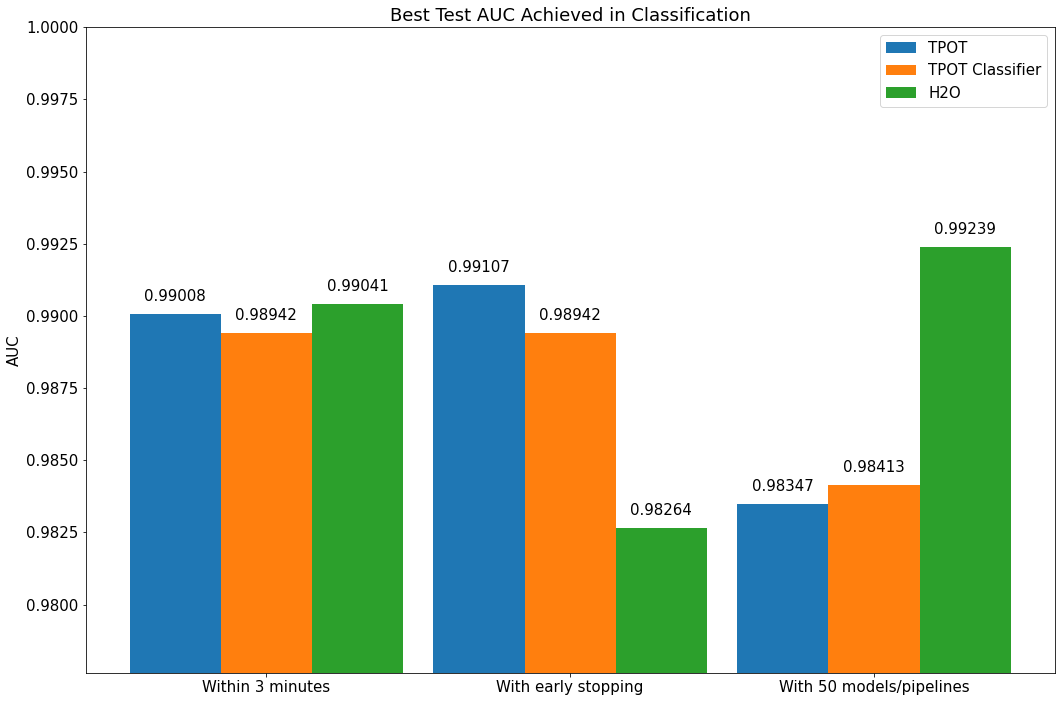

In [9]:
plot_scores(x, width, classification_scores, "classification", "test_plots/auc.png")

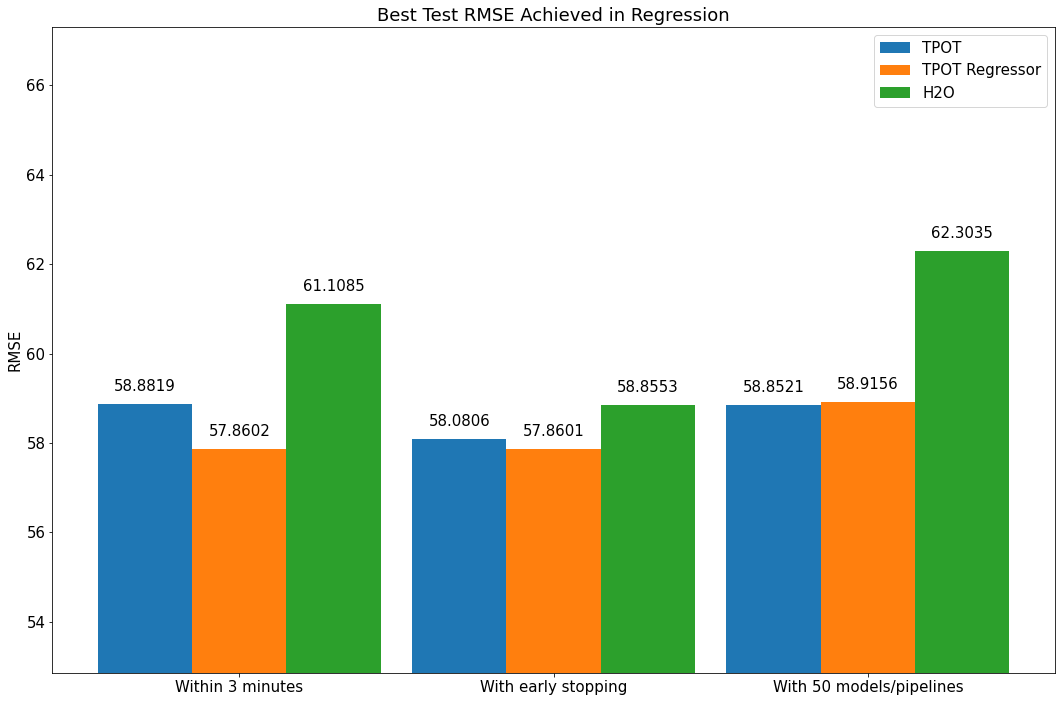

In [10]:
plot_scores(x, width, regression_scores, "regression", "test_plots/rmse.png")

In [11]:
# Function for plotting times
def plot_times(x, width, times, mode, save_dir):
    # Creating a figure and an ax
    fig, ax = plt.subplots()
    
    if mode == "classification":
        tpot_label = "Classifier"
    if mode == "regression":
        tpot_label = "Regressor"
    
    # Plotting times
    tpot_score = ax.bar(x - width, times["TPOT"], width, label="TPOT")
    tpot_cls_reg_score = score = ax.bar(x, times["TPOT (classifier/regressor only)"], width, label=f"TPOT {tpot_label}")
    tpot_h2o_score = ax.bar(x + width, times["H2O"], width, label="H2O")   
    
    # Setting ax title, ylabel, xticks, and xticklabels
    ax.set_title(f"Training Times in Minutes for {mode.capitalize()}")
    ax.set_ylabel("Minutes")
    ax.set_xticks(x)
    ax.set_xticklabels(["Within 3 minutes", "With early stopping", "With 50 models/pipelines"])

    # Setting the ylim based on provided times
    ylim = [np.max((0, times.min().min() - 50)), times.max().max() + 20]
    ax.set_ylim(ylim)

    # Plotting times
    ax.bar_label(tpot_score, padding=10)
    ax.bar_label(tpot_cls_reg_score, padding=10)
    ax.bar_label(tpot_h2o_score, padding=10)

    # Calling a legend
    ax.legend()

    # Adjusting subplot params to make the ax cleaner
    fig.tight_layout()
    
    # Saving the plot
    plt.savefig(save_dir)
    
    # Showing the plot
    plt.show()

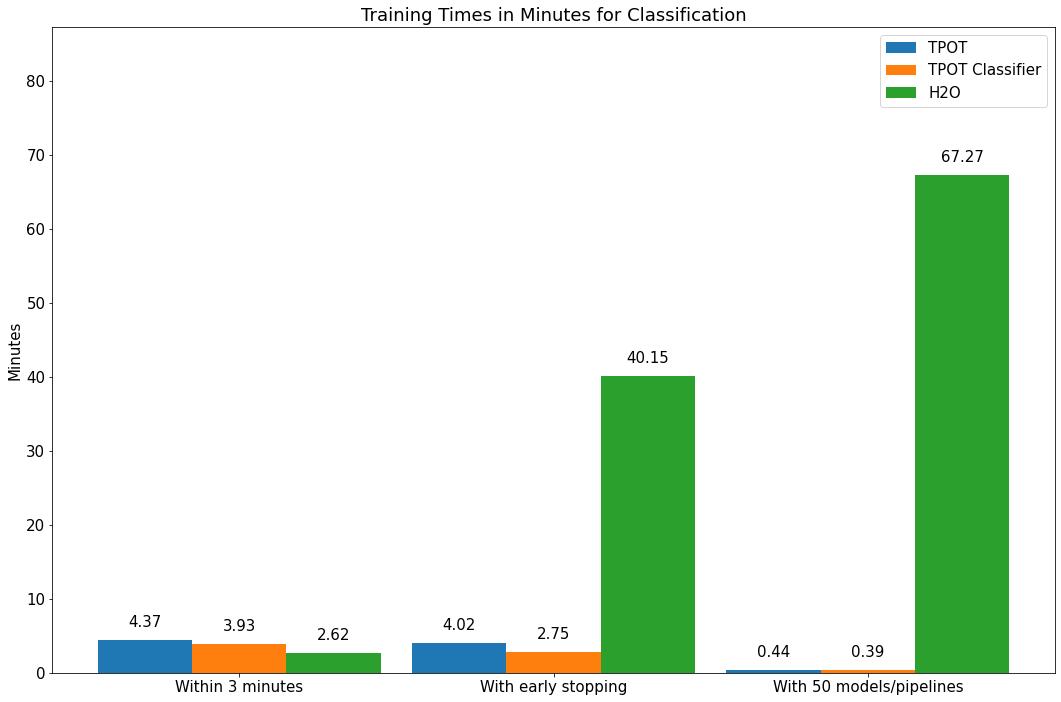

In [12]:
plot_times(x, width, classification_times, "classification", "test_plots/class_time.png")

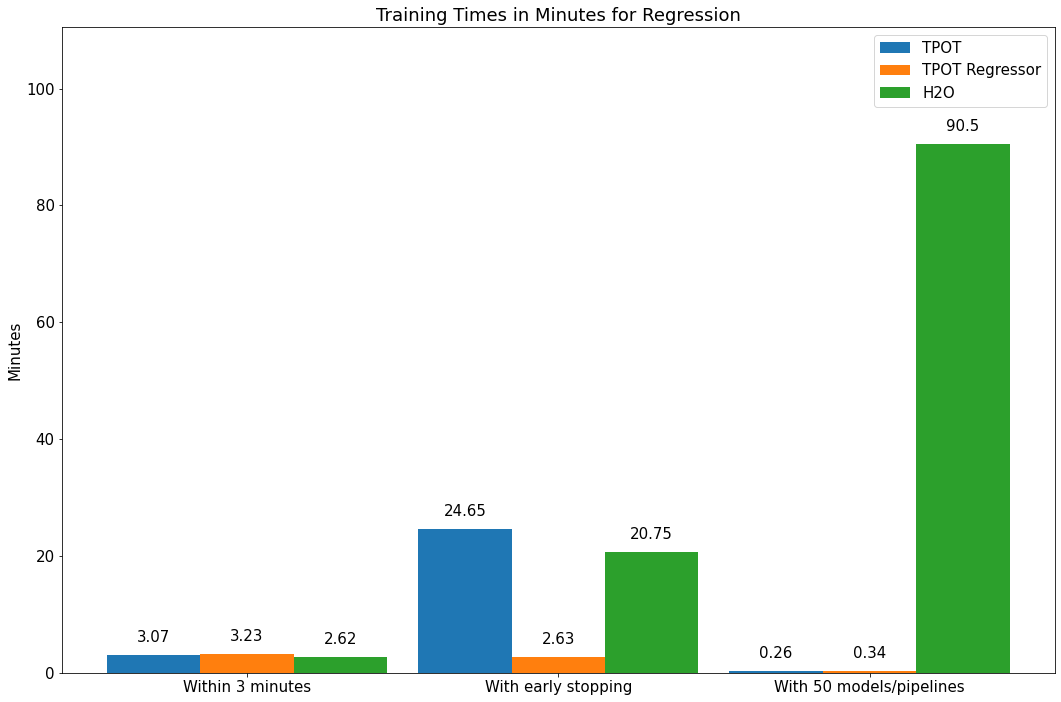

In [13]:
plot_times(x, width, regression_times, "regression",  "test_plots/regr_time.png")